In [1]:
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in RMS data for tests

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
rms = {}

for test in exps:
    rms[test] = RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass


Loaded Test 5 RMS Data

Loaded Test 7 RMS Data

Loaded Test 8 RMS Data

Loaded Test 9 RMS Data


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [4]:
autoe = {}
for test in exps:
        # autoe[test] = VariationalAutoEncoder(rms[test],
        #                                    tb=False,
        #                                    tb_logdir=rms[test].exp_name,
        #                                    train_slice=(0, 50),
        #                                    random_state=1,
        #                                    params={'latent_dim': 2,
        #                                            'n_size': [32, 16],
        #                                            'epochs': 300,
        #                                            'batch_size': 20,
        #                                            'callbacks': [
        #                                                    tf.keras.callbacks.EarlyStopping(
        #                                                         monitor='val_loss',
        #                                                         patience=30,
        #                                                         mode='min',
        #                                                         start_from_epoch=100,
        #                                                    ),
        #                                                 ]
        #                                            }
        #                                    )
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name,
                                  train_slice=(0, 65),
                                  val_frac=0.1,
                                  random_state=2,
                                  params={'n_bottleneck': 5,
                                          'n_size': [32,32],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=40,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 407)
	Input val shape: (7, 407)

AUTOE-TEST_5-E-750-L-[32, 32, 5, 32, 32]-20230504-164946

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 410)
	Input val shape: (7, 410)

AUTOE-TEST_7-E-750-L-[32, 32, 5, 32, 32]-20230504-164946

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 393)
	Input val shape: (7, 393)

AUTOE-TEST_8-E-750-L-[32, 32, 5, 32, 32]-20230504-164946

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 394)
	Input val shape: (7, 394)

AUTOE-TEST_9-E-750-L-[32, 32, 5, 32, 32]-20230504-164946



In [5]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=Path.cwd().joinpath('..', 'models', rms[test].exp_name, f'{name}_best.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [6]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [17]:
for test in exps:
    autoe[test].model.model_.load_weights(Path.cwd().joinpath('..', 'models', rms[test].exp_name, f'{autoe[test].run_name}_best.h5'))
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

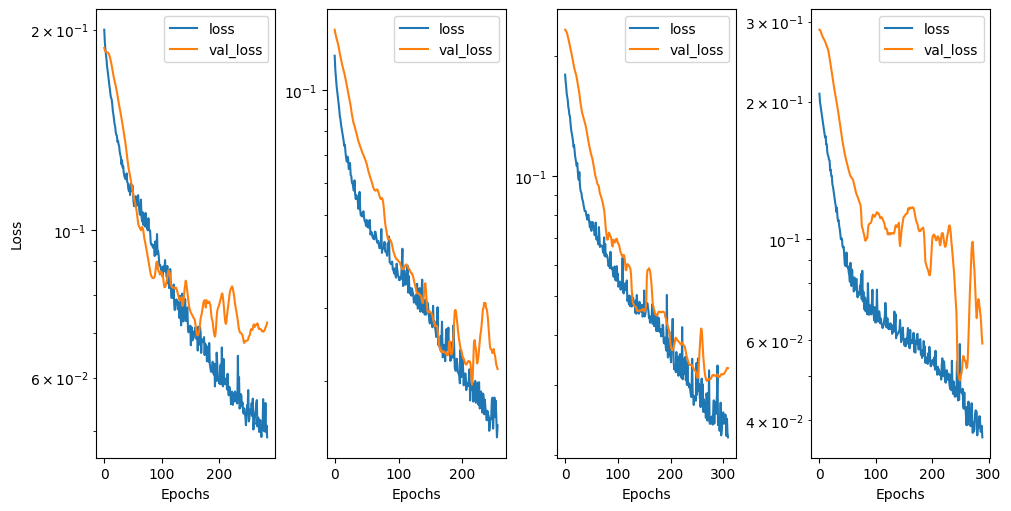

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(10,5), constrained_layout=True)
ax = ax.ravel()
for i, test in enumerate(exps):
    autoe[test].loss_plot(plt_ax=ax[i])
    ax[i].set_yscale('log')
    if i > 0:
        ax[i].set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [19]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Train Scores:
	MAE: 0.17801
	MSE: 0.05442
	R2: -0.04029

Val Scores:
	MAE: 0.19825
	MSE: 0.06770
	R2: -0.18135

Dataset Scores:
	MAE: 0.44684
	MSE: 0.48437
	R2: -0.84089

 Test 7

Train Scores:
	MAE: 0.10136
	MSE: 0.01853
	R2: 0.24816

Val Scores:
	MAE: 0.10406
	MSE: 0.01957
	R2: 0.29242

Dataset Scores:
	MAE: 0.13622
	MSE: 0.03810
	R2: 0.08325

 Test 8

Train Scores:
	MAE: 0.11941
	MSE: 0.02538
	R2: 0.36002

Val Scores:
	MAE: 0.13161
	MSE: 0.03068
	R2: 0.31973

Dataset Scores:
	MAE: 0.18891
	MSE: 0.13792
	R2: 0.26505

 Test 9

Train Scores:
	MAE: 0.15235
	MSE: 0.04029
	R2: -0.07612

Val Scores:
	MAE: 0.17063
	MSE: 0.04892
	R2: -0.13382

Dataset Scores:
	MAE: 0.39895
	MSE: 0.37363
	R2: -1.04720


## Show histogram of scores across whole dataset

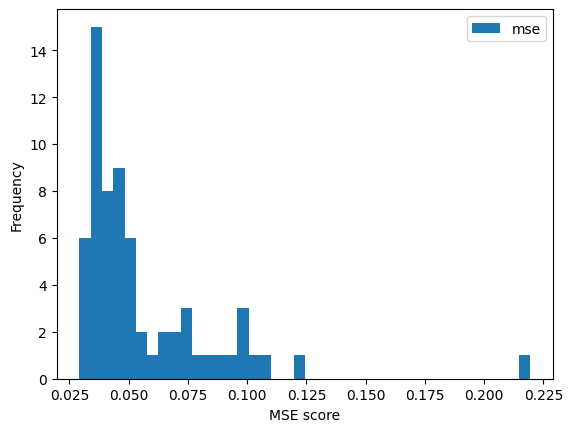

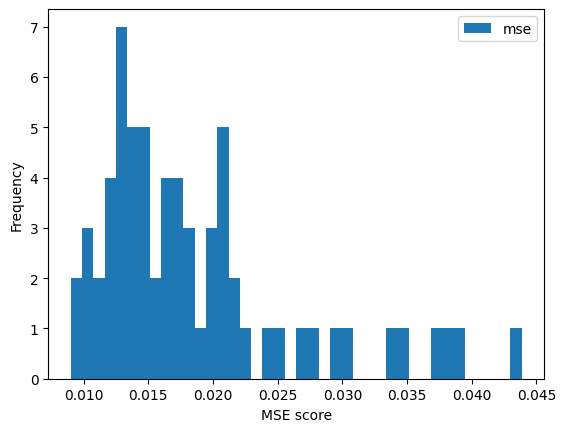

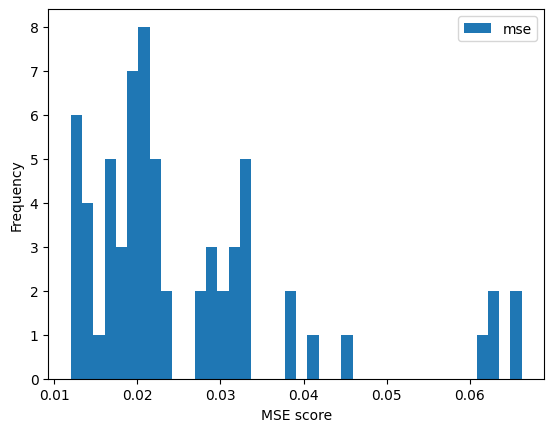

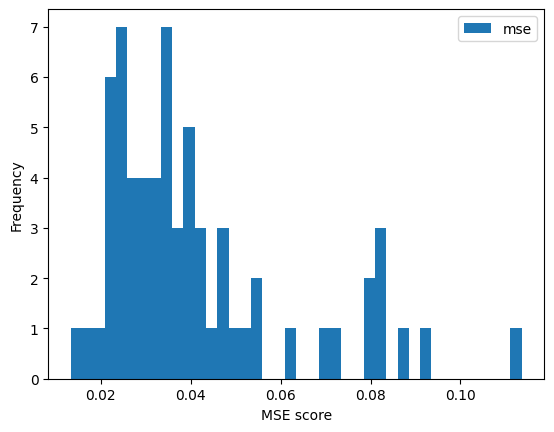

In [20]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

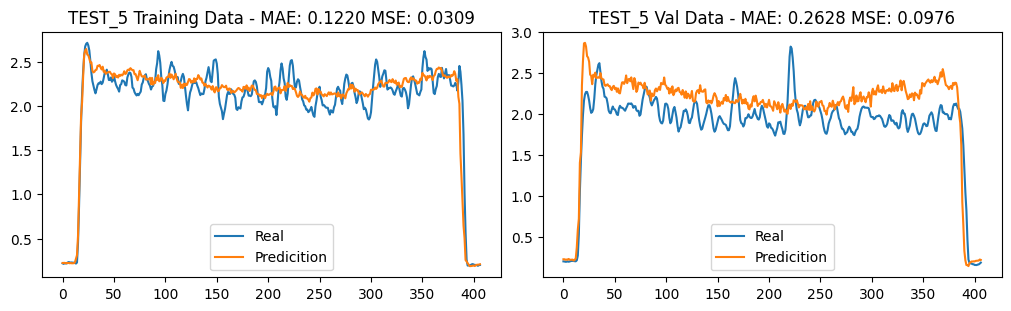

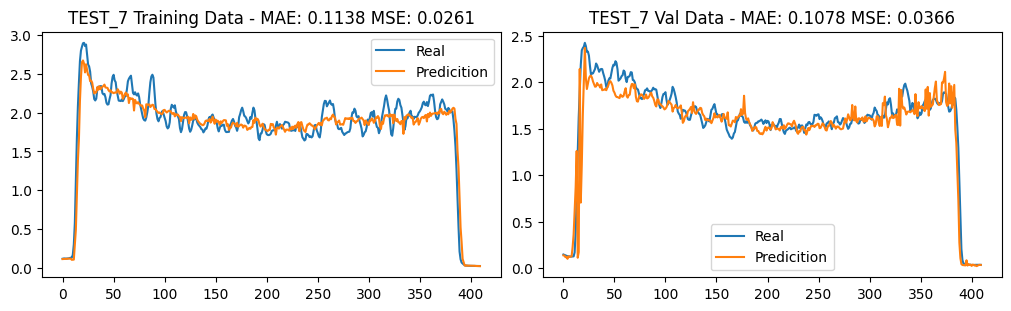

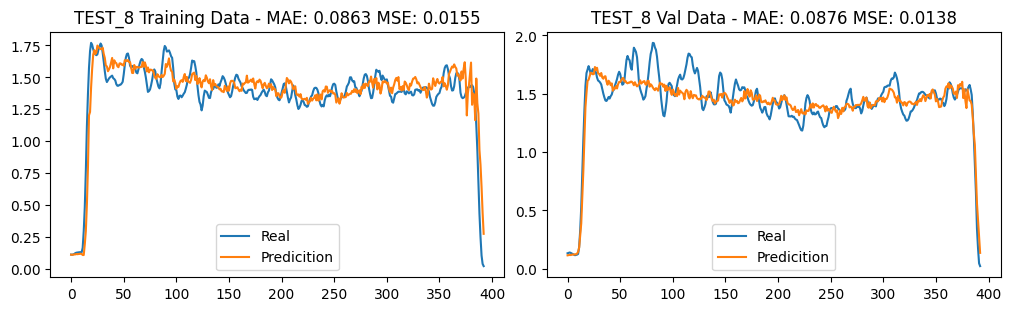

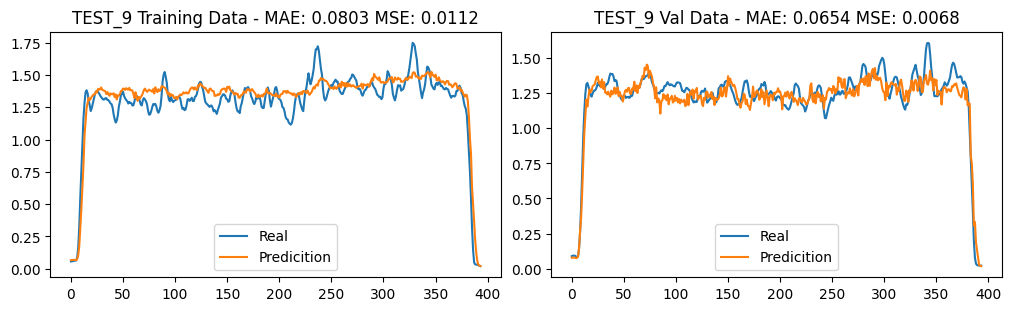

In [21]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [22]:
for test in exps:
    autoe[test].thres

## Show scores against threshold

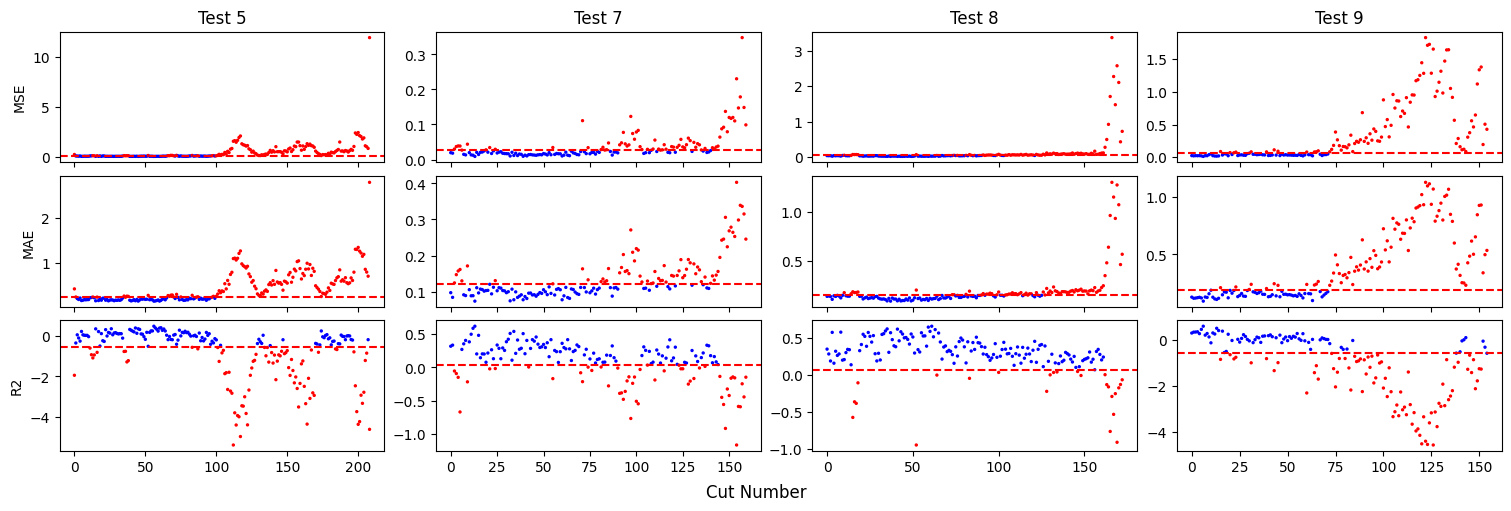

In [23]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

for i, test in enumerate(exps):
    ax[0, i].set_title(test)    
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=ax[j, i])

        ax[j, i].set_ylabel('')
        ax[j, i].set_xlabel('')
        ax[j, 0].set_ylabel(f'{met.upper()}')
_ = fig.supxlabel('Cut Number')

In [24]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  209.000000  209.000000  209.000000
mean     0.446835    0.484375   -0.840887
std      0.352055    0.955187    1.306523
min      0.135530    0.029218   -5.398994
25%      0.179277    0.052952   -1.237145
50%      0.293598    0.151413   -0.271431
75%      0.599844    0.618220    0.055631
max      2.801497   11.890598    0.482652

 Test 7
              mae         mse          r2
count  160.000000  160.000000  160.000000
mean     0.136221    0.038104    0.083245
std      0.058675    0.042305    0.300045
min      0.073614    0.009000   -1.165069
25%      0.099227    0.017059   -0.047037
50%      0.112593    0.023287    0.144217
75%      0.153014    0.038500    0.289002
max      0.403000    0.347718    0.619150

 Test 8
              mae         mse          r2
count  173.000000  173.000000  173.000000
mean     0.188912    0.137921    0.265049
std      0.191705    0.430354    0.266967
min      0.084620    0.011978   -0.946030
25%    

## autoe models latent space

In [25]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

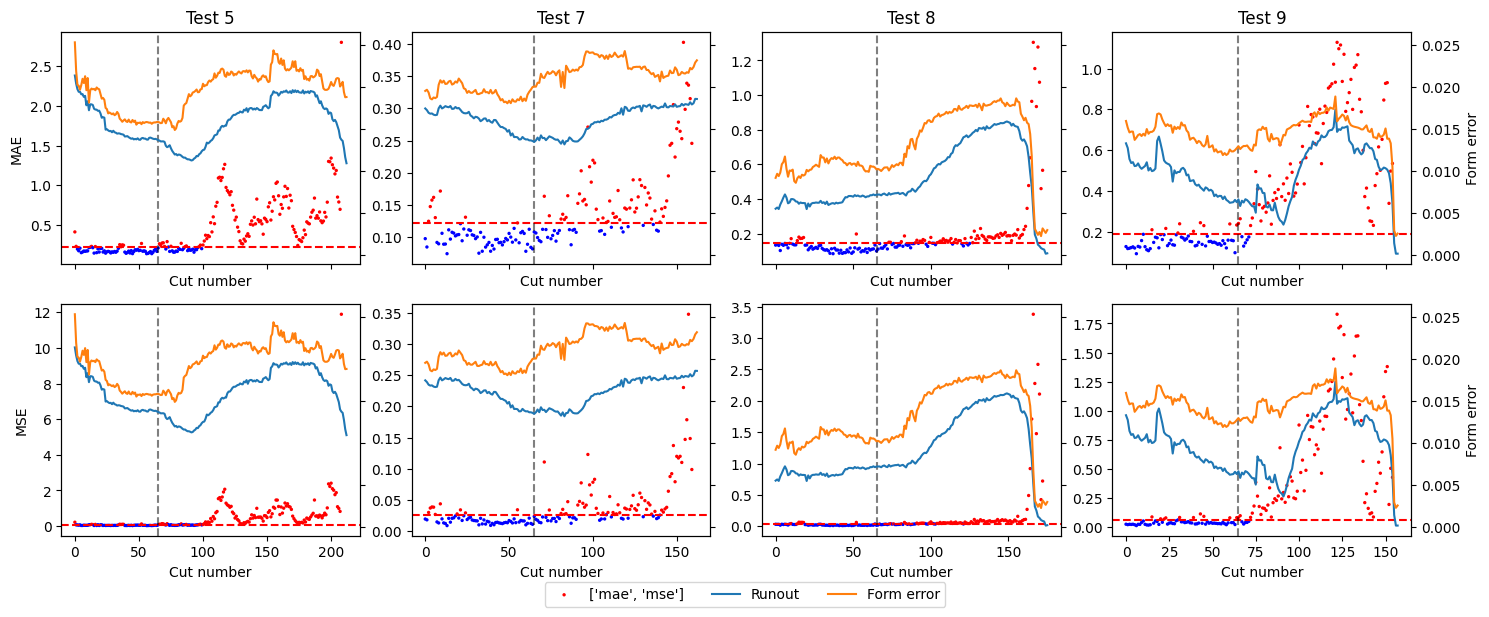

In [26]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

for i, test in enumerate(exps):
    ax[0, i].set_title(test)
    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=ax[j, i])
        # vert line to show where training data ends
        ax[j, i].axvline(autoe[test]._train_slice.stop,
                         color='k',
                         linestyle='--',
                         alpha=0.5,
                         )
        for feature in features:
            feat = exp.features[feature]
            ax2[j, i].plot(range(len(feat)), feat, label=feature)

        ax[j, i].set_ylabel('')
        ax[j, 0].set_ylabel(f'{met.upper()}')
        ax2[j, -1].set_ylabel(f'{feature}')
        # if j == 1:
        #    ax[j, i].set_ylim([0, 2]) 

for i, a in enumerate(ax2.ravel()):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = ax.ravel()[0].get_legend_handles_labels()
l2, lab2 = ax2.ravel()[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()